In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
# EasyOCR 사용

from ITT import (
    preprocess_image,           # 이미지 로드 (컬러 이미지 반환)
    ocr_with_structure,         # EasyOCR로 단어 단위 탐지
    group_by_line,              # 라인 단위 그룹화
    group_by_paragraph,         # 문단 단위 그룹화
    generate_text_from_data,    # 텍스트 생성
    call_llm_for_correction,    # OCR 교정 (LLM)
    call_llm_for_description,   # LLM 설명 생성
    save_output                 # 결과 저장
)

# 테스트용 이미지 경로
IMAGE_PATH = "img/img_to_text_sample_3.png"
print(f"테스트 이미지: {IMAGE_PATH}")


테스트 이미지: img/img_to_text_sample_3.png


이미지 shape: (1200, 1904, 3)
이미지 dtype: uint8
채널 수: 3


(np.float64(-0.5), np.float64(1903.5), np.float64(1199.5), np.float64(-0.5))

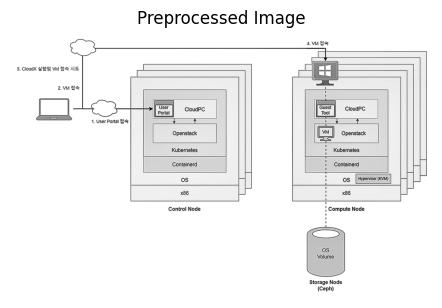

In [158]:
# Step 1: preprocess_image 테스트
# preprocess_image는 원본 컬러 이미지를 반환합니다 (EasyOCR은 컬러 이미지도 처리 가능)
import cv2
import matplotlib.pyplot as plt

img = preprocess_image(IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"이미지 shape: {img.shape}")
print(f"이미지 dtype: {img.dtype}")
print(f"채널 수: {img.shape[2] if len(img.shape) == 3 else 1}")

# 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Preprocessed Image")
plt.imshow(img)
plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title("Image for OCR (RGB)")
# plt.imshow(img_rgb)
# plt.axis('off')

# plt.tight_layout()
# plt.show()


c:\Users\INSoft\miniconda3\envs\sk\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


탐지된 단어 개수: 28

처음 10개 단어:
  [1] '4.VM 접속' at (1334, 42) conf=68% line=1
  [2] '3. CloudX 실행및 VI 접속 시드' at (30, 156) conf=51% line=2
  [3] '2 VI 접속' at (212, 242) conf=82% line=3
  [4] 'User' at (668, 332) conf=91% line=4
  [5] 'Guest' at (1390, 332) conf=99% line=4
  [6] 'CloudPC' at (1504, 334) conf=99% line=4
  [7] 'CloudPC' at (784, 338) conf=99% line=4
  [8] 'Portal' at (662, 354) conf=92% line=5
  [9] 'Tool' at (1398, 354) conf=99% line=5
  [10] '1. User Portal 접속' at (366, 392) conf=66% line=6


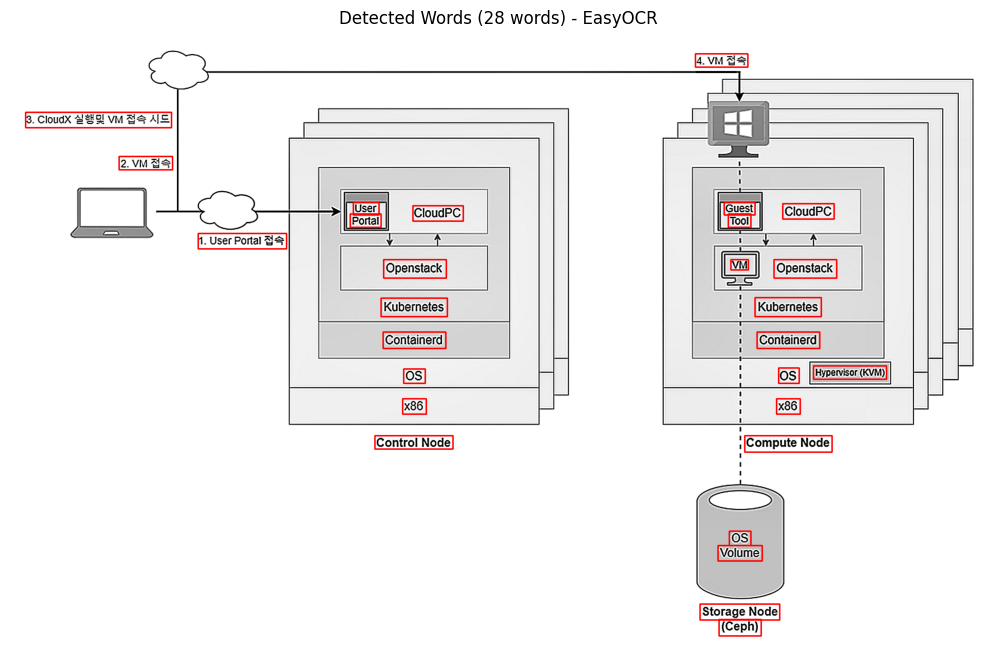

In [159]:
# Step 2: ocr_with_structure 테스트 (EasyOCR 사용)
# 핵심: EasyOCR이 직접 단어 단위로 탐지! (한국어+영어 지원)
# 주의: 첫 실행 시 모델 다운로드가 필요할 수 있습니다 (1-2분 소요)

words_data = ocr_with_structure(img, level='word', langs=['ko', 'en'])

print(f"탐지된 단어 개수: {len(words_data)}")
print(f"\n처음 10개 단어:")
for i, w in enumerate(words_data[:10]):
    print(f"  [{i+1}] '{w['text']}' at ({w['x']}, {w['y']}) conf={w['conf']}% line={w.get('line_num', 'N/A')}")

# 시각화: 탐지된 단어 박스 표시
img_with_boxes = img_rgb.copy()
for w in words_data:
    cv2.rectangle(img_with_boxes, (w['x'], w['y']), (w['x']+w['w'], w['y']+w['h']), (255, 0, 0), 2)

plt.figure(figsize=(14, 8))
plt.title(f"Detected Words ({len(words_data)} words) - EasyOCR")
plt.imshow(img_with_boxes)
plt.axis('off')
plt.show()


그룹화된 라인 개수: 28

각 라인 내용 (처음 15개):
  Line 1 (line_num=0): '4.VM 접속'
  Line 2 (line_num=1): '3. CloudX 실행및 VI 접속 시드'
  Line 3 (line_num=2): '2 VI 접속'
  Line 4 (line_num=3): 'User'
  Line 5 (line_num=4): 'Guest'
  Line 6 (line_num=5): 'CloudPC'
  Line 7 (line_num=6): 'CloudPC'
  Line 8 (line_num=7): 'Portal'
  Line 9 (line_num=8): 'Tool'
  Line 10 (line_num=9): '1. User Portal 접속'
  Line 11 (line_num=10): 'Openstack'
  Line 12 (line_num=11): 'VM'
  Line 13 (line_num=12): 'Openstack'
  Line 14 (line_num=13): 'Kubernetes'
  Line 15 (line_num=14): 'Kubernetes'
  ... (총 28개 라인)


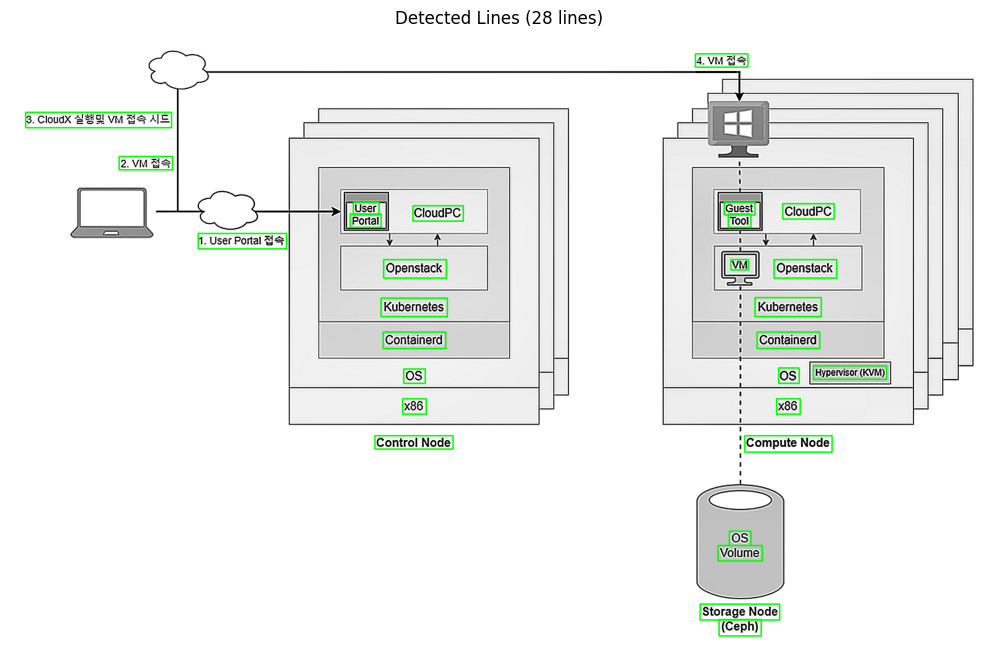

In [160]:


# Step 3: group_by_line 테스트 (라인 단위 그룹화)
lines_data = group_by_line(words_data)

print(f"그룹화된 라인 개수: {len(lines_data)}")
print(f"\n각 라인 내용 (처음 15개):")
for i, line in enumerate(lines_data[:15]):
    preview = line['text'][:60] + '...' if len(line['text']) > 60 else line['text']
    print(f"  Line {i+1} (line_num={line.get('line_num', 'N/A')}): '{preview}'")

if len(lines_data) > 15:
    print(f"  ... (총 {len(lines_data)}개 라인)")

# 시각화: 라인 박스 표시
img_with_lines = img_rgb.copy()
for line in lines_data:
    cv2.rectangle(img_with_lines, (line['x'], line['y']), 
                  (line['x']+line['w'], line['y']+line['h']), (0, 255, 0), 2)

plt.figure(figsize=(14, 8))
plt.title(f"Detected Lines ({len(lines_data)} lines)")
plt.imshow(img_with_lines)
plt.axis('off')
plt.show()


그룹화된 문단 개수: 6

각 문단 내용 (처음 10개):
  Paragraph 1 (para_num=0): '4.VM 접속'
  Paragraph 2 (para_num=1): '3. CloudX 실행및 VI 접속 시드'
  Paragraph 3 (para_num=2): '2 VI 접속'
  Paragraph 4 (para_num=3): 'User Guest CloudPC CloudPC Portal Tool 1. User Portal 접속 Openstack VM Openstack ...'
  Paragraph 5 (para_num=4): 'OS Volume'
  Paragraph 6 (para_num=5): 'Storage Node (Ceph)'


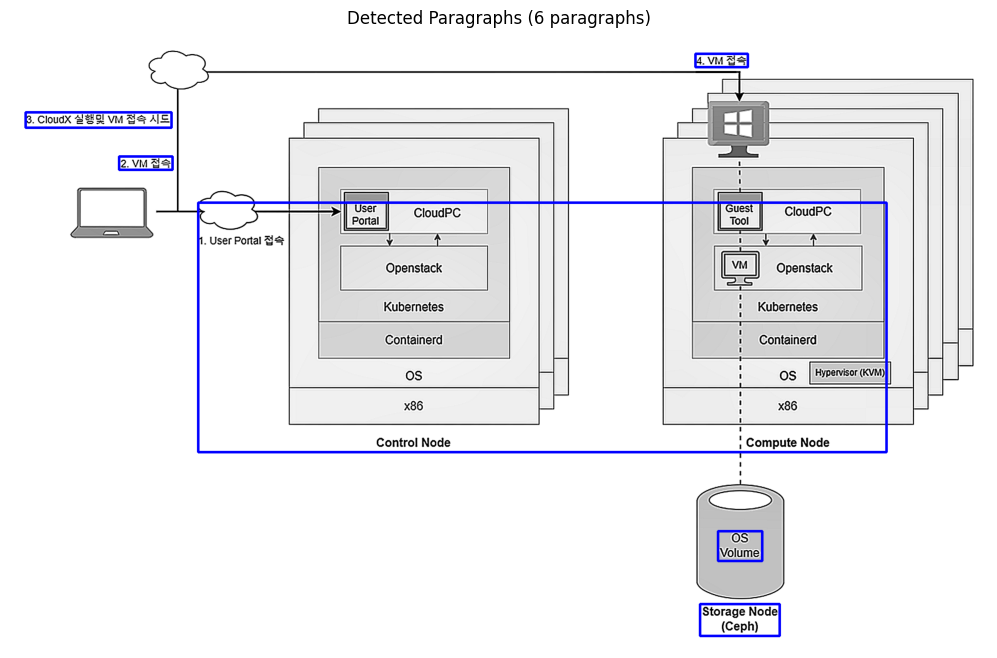

In [161]:
# Step 4: group_by_paragraph 테스트 (문단 단위 그룹화)
# 라인 간격 기반으로 문단 구성 (평균 라인 높이의 1.5배 이상이면 새 문단)
paragraphs_data = group_by_paragraph(words_data, para_threshold_ratio=1.5)

print(f"그룹화된 문단 개수: {len(paragraphs_data)}")
print(f"\n각 문단 내용 (처음 10개):")
for i, para in enumerate(paragraphs_data[:10]):
    preview = para['text'][:80] + '...' if len(para['text']) > 80 else para['text']
    print(f"  Paragraph {i+1} (para_num={para.get('paragraph_num', 'N/A')}): '{preview}'")

if len(paragraphs_data) > 10:
    print(f"  ... (총 {len(paragraphs_data)}개 문단)")

# 시각화: 문단 박스 표시
img_with_paras = img_rgb.copy()
for para in paragraphs_data:
    cv2.rectangle(img_with_paras, (para['x'], para['y']), 
                  (para['x']+para['w'], para['y']+para['h']), (0, 0, 255), 3)

plt.figure(figsize=(14, 8))
plt.title(f"Detected Paragraphs ({len(paragraphs_data)} paragraphs)")
plt.imshow(img_with_paras)
plt.axis('off')
plt.show()


In [162]:
# Step 5: 전체 텍스트 생성 (LLM에 보낼 텍스트)
# 라인 단위로 전체 텍스트 생성
full_text = generate_text_from_data(lines_data)

print("="*60)
print("추출된 전체 텍스트 (라인 단위):")
print("="*60)
print(full_text)
print("="*60)
print(f"\n총 {len(full_text)} 글자")


추출된 전체 텍스트 (라인 단위):
4.VM 접속
3. CloudX 실행및 VI 접속 시드
2 VI 접속
User
Guest
CloudPC
CloudPC
Portal
Tool
1. User Portal 접속
Openstack
VM
Openstack
Kubernetes
Kubernetes
Containerd
Containerd
Hypervisor (KVM)
OS
OS
X86
X86
Control Node
Compute Node
OS
Volume
Storage Node
(Ceph)

총 249 글자


In [163]:
# Step 5.5: OCR 교정 (LLM을 활용한 오타 수정)
# OCR 결과에 포함된 오류를 LLM으로 자동 교정
LLM_SERVER_URL = "http://gpurent.kogrobo.com:51089/v1"

print("[INFO] OCR 교정 시작...")
print("원본 텍스트에 오류가 있는지 확인하고 수정합니다...\n")

# 전체 텍스트를 LLM으로 교정
corrected_text = call_llm_for_correction(full_text, LLM_SERVER_URL)

if corrected_text != full_text:
    print("="*60)
    print("교정 결과:")
    print("="*60)
    
    # 교정된 텍스트를 라인별로 분할하여 lines_data 업데이트
    corrected_lines = corrected_text.split('\n')
    
    print(f"교정 전 라인 수: {len(lines_data)}")
    print(f"교정 후 라인 수: {len(corrected_lines)}")
    
    # lines_data 업데이트
    for i, line_item in enumerate(lines_data):
        if i < len(corrected_lines):
            original = line_item['text']
            corrected = corrected_lines[i].strip()
            line_item['text'] = corrected
            line_item['corrected'] = (original != corrected)
            
            # 변경된 라인만 표시
            if original != corrected:
                print(f"\n[수정] Line {i+1}:")
                print(f"  원본: {original}")
                print(f"  교정: {corrected}")
        else:
            line_item['corrected'] = False
    
    # 교정된 전체 텍스트 업데이트
    full_text = corrected_text
    
    print("\n" + "="*60)
    print("교정 완료!")
    print("="*60)
else:
    print("[INFO] OCR 교정: 변경사항 없음 (오류가 없거나 감지되지 않음)")
    # 교정되지 않았음을 표시
    for line_item in lines_data:
        line_item['corrected'] = False

print(f"\n교정된 전체 텍스트 (처음 300글자):")
print("-"*60)
print(full_text[:300] + "..." if len(full_text) > 300 else full_text)
print("-"*60)


[INFO] OCR 교정 시작...
원본 텍스트에 오류가 있는지 확인하고 수정합니다...

교정 결과:
교정 전 라인 수: 28
교정 후 라인 수: 31

[수정] Line 1:
  원본: 4.VM 접속
  교정: 4. VM 접속

[수정] Line 2:
  원본: 3. CloudX 실행및 VI 접속 시드
  교정: 3. CloudX 실행 및 VI 접속 시드

[수정] Line 3:
  원본: 2 VI 접속
  교정: 2. VI 접속

[수정] Line 4:
  원본: User
  교정: 

[수정] Line 5:
  원본: Guest
  교정: User

[수정] Line 6:
  원본: CloudPC
  교정: Guest

[수정] Line 8:
  원본: Portal
  교정: CloudPC

[수정] Line 9:
  원본: Tool
  교정: Portal

[수정] Line 10:
  원본: 1. User Portal 접속
  교정: Tool

[수정] Line 11:
  원본: Openstack
  교정: 

[수정] Line 12:
  원본: VM
  교정: 1. User Portal 접속

[수정] Line 13:
  원본: Openstack
  교정: 

[수정] Line 14:
  원본: Kubernetes
  교정: Openstack

[수정] Line 15:
  원본: Kubernetes
  교정: VM

[수정] Line 16:
  원본: Containerd
  교정: Openstack

[수정] Line 17:
  원본: Containerd
  교정: Kubernetes

[수정] Line 18:
  원본: Hypervisor (KVM)
  교정: Kubernetes

[수정] Line 19:
  원본: OS
  교정: Containerd

[수정] Line 20:
  원본: OS
  교정: Containerd

[수정] Line 21:
  원본: X86
  교정: Hypervisor (KVM)

[수정] Line 22:
  원본: X

In [164]:
# Step 6: LLM 내용 설명 생성
# 교정된 텍스트(full_text)를 사용하여 이미지 내용 설명 생성
# LLM_SERVER_URL은 Step 5.5에서 이미 정의됨

print("[INFO] LLM에 텍스트 전송 중...")
print("교정된 텍스트를 기반으로 이미지 내용을 분석합니다...\n")

description = call_llm_for_description(full_text, LLM_SERVER_URL)

if description:
    print("\n" + "="*60)
    print("LLM 이미지 내용 설명:")
    print("="*60)
    print(description)
    print("="*60)
else:
    print("[WARN] LLM 설명이 생성되지 않았습니다.")


[INFO] LLM에 텍스트 전송 중...
교정된 텍스트를 기반으로 이미지 내용을 분석합니다...


LLM 이미지 내용 설명:
이 그림은 **클라우드 환경에서 사용자가 가상 머신(VM)에 접속하고, 그 위에서 실행되는 서비스들이 어떻게 계층적으로 구성되는지를 한눈에 보여주는 아키텍처 다이어그램**입니다.  
아래는 OCR로 추출된 텍스트를 바탕으로 이미지에 나타난 흐름과 구성 요소들을 자연스럽게 정리한 내용입니다.

---

## 1. 최상위 – 사용자 입장

1️⃣ **User Portal 접속**  
- 가장 위쪽에 “User Portal”이라는 항목이 있습니다.  
- 여기서는 최종 사용자가 웹 브라우저 등을 통해 **포털에 로그인**하고, 자신에게 할당된 클라우드 서비스를 요청하는 단계입니다.

2️⃣ **User / Guest**  
- 포털에 로그인한 사용자는 “User” 혹은 “Guest” 형태로 구분됩니다.  
- 이 단계는 실제 서비스 이용 권한(일반 사용자 vs 제한된 게스트) 차이를 나타냅니다.

---

## 2. 클라우드 데스크톱 (CloudPC)

- 포털에 로그인하면 **“CloudPC”** 라는 가상의 데스크톱 환경이 제공됩니다.  
- 사용자는 이 CloudPC를 통해 원격으로 **VM에 접속**하거나, 클라우드 기반 애플리케이션을 실행합니다.

---

## 3. 가상 머신 (VM) 접속 흐름

### 3️⃣ **VI 접속** (Virtual Interface)
- CloudPC에서 **“VI 접속”** 단계가 표시됩니다. 이는 가상 머신에 연결하기 위한 네트워크 인터페이스(또는 콘솔) 접속을 의미합니다.

### 4️⃣ **CloudX 실행 및 VI 접속 시드**
- “CloudX”라는 이름의 클라우드 관리 툴(또는 에이전트)이 실행됩니다.  
- 이 툴이 **VI 접속 시드**(접속 정보를 초기화·전달하는 역할)를 제공해, 사용자가 VM에 원활히 접속할 수 있게 합니다.

### 5️⃣ **VM 접속**
- 최종적으로 사용

In [ ]:
# Step 7: 결과 저장
TXT_PATH = "output/output.txt"
CSV_PATH = "output/output.csv"

# 라인 단위로 저장
save_output(lines_data, TXT_PATH, CSV_PATH, description)

print(f"[완료] TXT 저장: {TXT_PATH}")
print(f"[완료] CSV 저장: {CSV_PATH}")
print(f"[완료] 저장된 라인 수: {len(lines_data)}")

# 저장된 파일 미리보기
print("\n" + "="*60)
print("저장된 TXT 파일 내용 (미리보기 - 처음 500글자):")
print("="*60)
with open(TXT_PATH, 'r', encoding='utf-8') as f:
    content = f.read()
    print(content[:500] + "..." if len(content) > 500 else content)
    print(f"\n... (총 {len(content)} 글자)")
